<a href="https://colab.research.google.com/github/mwang-cmn/Stock-Market-Portfolio-Optimization/blob/main/Portfolio_analysis_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyfolio
!pip install riskfolio-lib

In [4]:
import pandas as pd
import yfinance as yf
import riskfolio as rp
import pyfolio as pf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import date, timedelta

/usr/local/lib/python3.11/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [5]:
end_date = date.today()
start_date = (date.today() - timedelta(days=180)).strftime("%Y-%m-%d")

assets = ["TSLA", "NVDA", "META", "WFC", "T", "AMZN", "PANW", "AAPL", "MSFT", "QQQ"]
data = yf.download(assets, start = start_date, end = end_date, progress=False)
data = data.loc[:, "Close"].dropna()
data.head()

YF.download() has changed argument auto_adjust default to True


Ticker,AAPL,AMZN,META,MSFT,NVDA,PANW,QQQ,T,TSLA,WFC
Date,,,,,,,,,,
2024-10-07,221.203171,180.800003,583.789368,407.903992,127.699455,168.970001,480.607147,21.234377,240.830002,56.553322
2024-10-08,225.274200,182.720001,591.885559,413.053345,132.868622,177.565002,487.784851,21.312372,244.500000,56.691837
2024-10-09,229.035919,185.169998,589.509583,415.792328,132.628647,181.434998,491.622925,21.380619,241.050003,56.929291
2024-10-10,228.537003,186.649994,582.840881,414.178833,134.788300,184.699997,491.064667,20.954033,238.770004,57.137062
2024-10-11,227.050293,188.820007,588.950562,414.656891,134.778320,186.600006,491.832275,21.102154,217.800003,60.342670


Calculate Returns for each stock

In [6]:
returns = data.pct_change().dropna()
returns

Ticker,AAPL,AMZN,META,MSFT,NVDA,PANW,QQQ,T,TSLA,WFC
Date,,,,,,,,,,
2024-10-08,0.018404,0.010619,0.013868,0.012624,0.040479,0.050867,0.014935,0.003673,0.015239,0.002449
2024-10-09,0.016698,0.013408,-0.004014,0.006631,-0.001806,0.021795,0.007868,0.003202,-0.014110,0.004188
2024-10-10,-0.002178,0.007993,-0.011312,-0.003881,0.016283,0.017995,-0.001136,-0.019952,-0.009459,0.003650
2024-10-11,-0.006505,0.011626,0.010483,0.001154,-0.000074,0.010287,0.001563,0.007069,-0.087825,0.056104
2024-10-14,0.016480,-0.006779,0.000797,0.006774,0.024258,0.001902,0.008391,-0.005147,0.006244,0.019184
...,...,...,...,...,...,...,...,...,...,...
2025-03-27,0.010473,0.001144,-0.013748,0.001564,-0.020482,-0.056877,-0.005698,0.019892,0.003933,-0.016197
2025-03-28,-0.026580,-0.042908,-0.042882,-0.030160,-0.015795,-0.009631,-0.026328,-0.000709,-0.035075,-0.021998
2025-03-31,0.019413,-0.012765,-0.000659,-0.009002,-0.011763,-0.012271,-0.000043,0.003549,-0.016657,0.015561


In [7]:
returns.median().sort_values(ascending=False).to_frame(name="Median_returns")


,Median_returns
Ticker,
T,0.003956
PANW,0.003179
NVDA,0.002451
AAPL,0.001484
MSFT,0.001111
QQQ,0.001090
AMZN,0.000800
META,0.000797
WFC,0.000412


Check for correlations

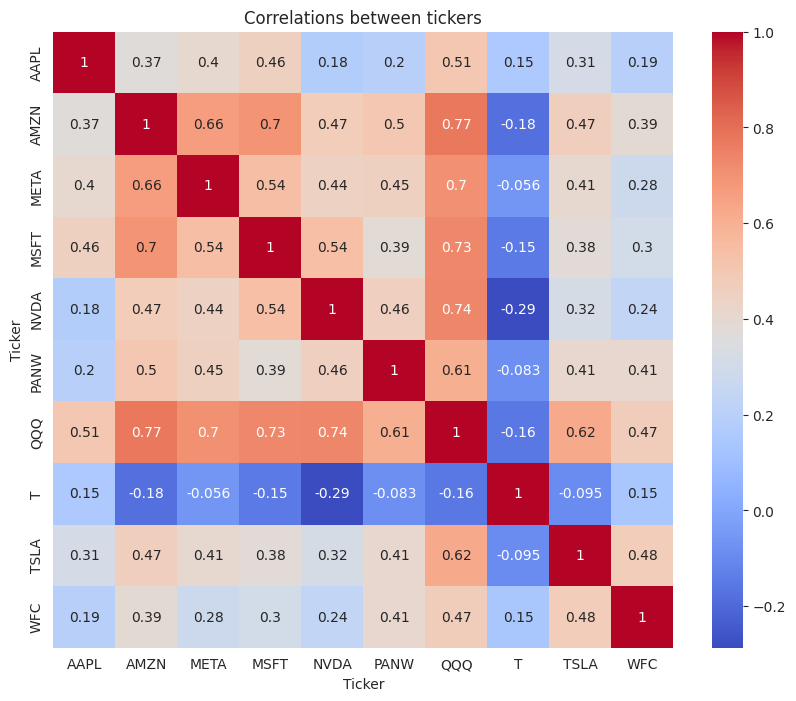

In [12]:
df_corr = returns.corr()
plt.figure(figsize=(10,8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.title("Correlations between tickers")
plt.show()

Seaborn clustermap - group correlations based on distance(Euclidean)

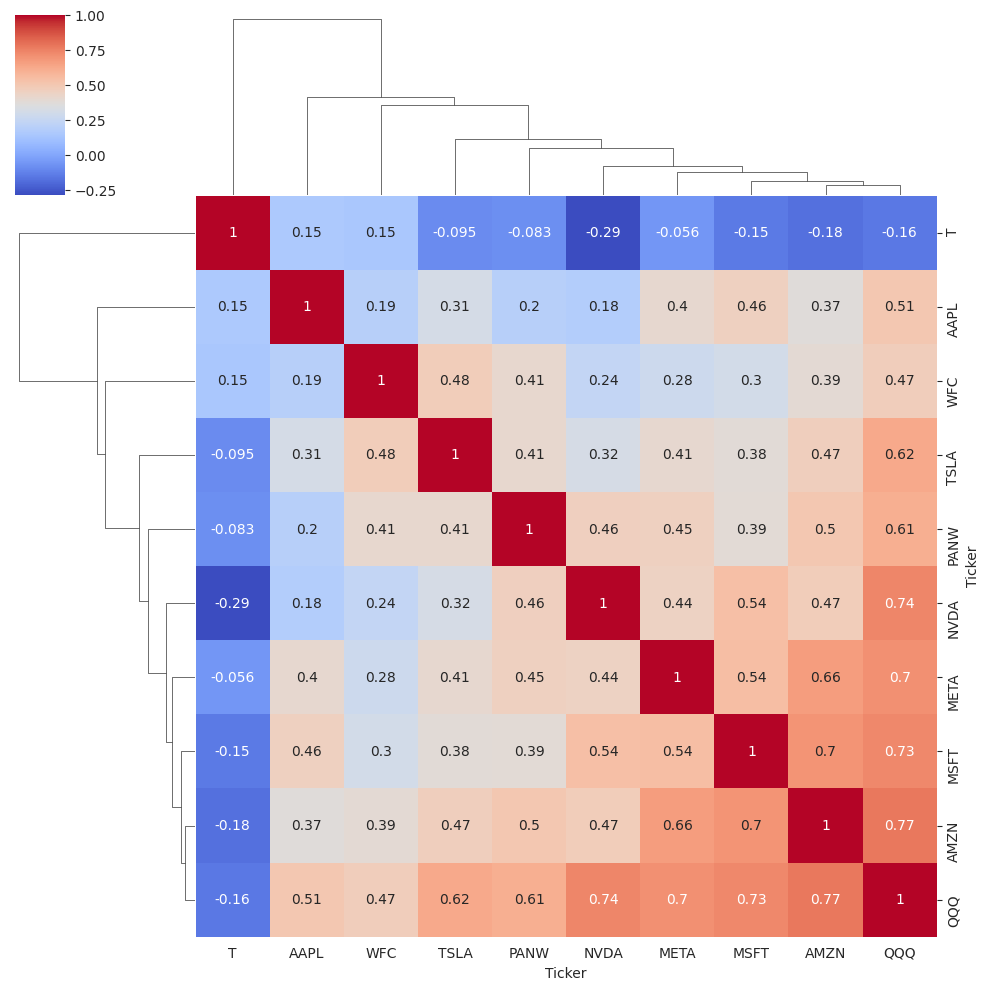

In [9]:
sns.clustermap(df_corr, cmap = 'coolwarm', metric="correlation", annot = True)
plt.show()

Riskfolio Clusterplot

To establish what groups exist and how to strategize an uncorrelated portfolio


<Axes: >

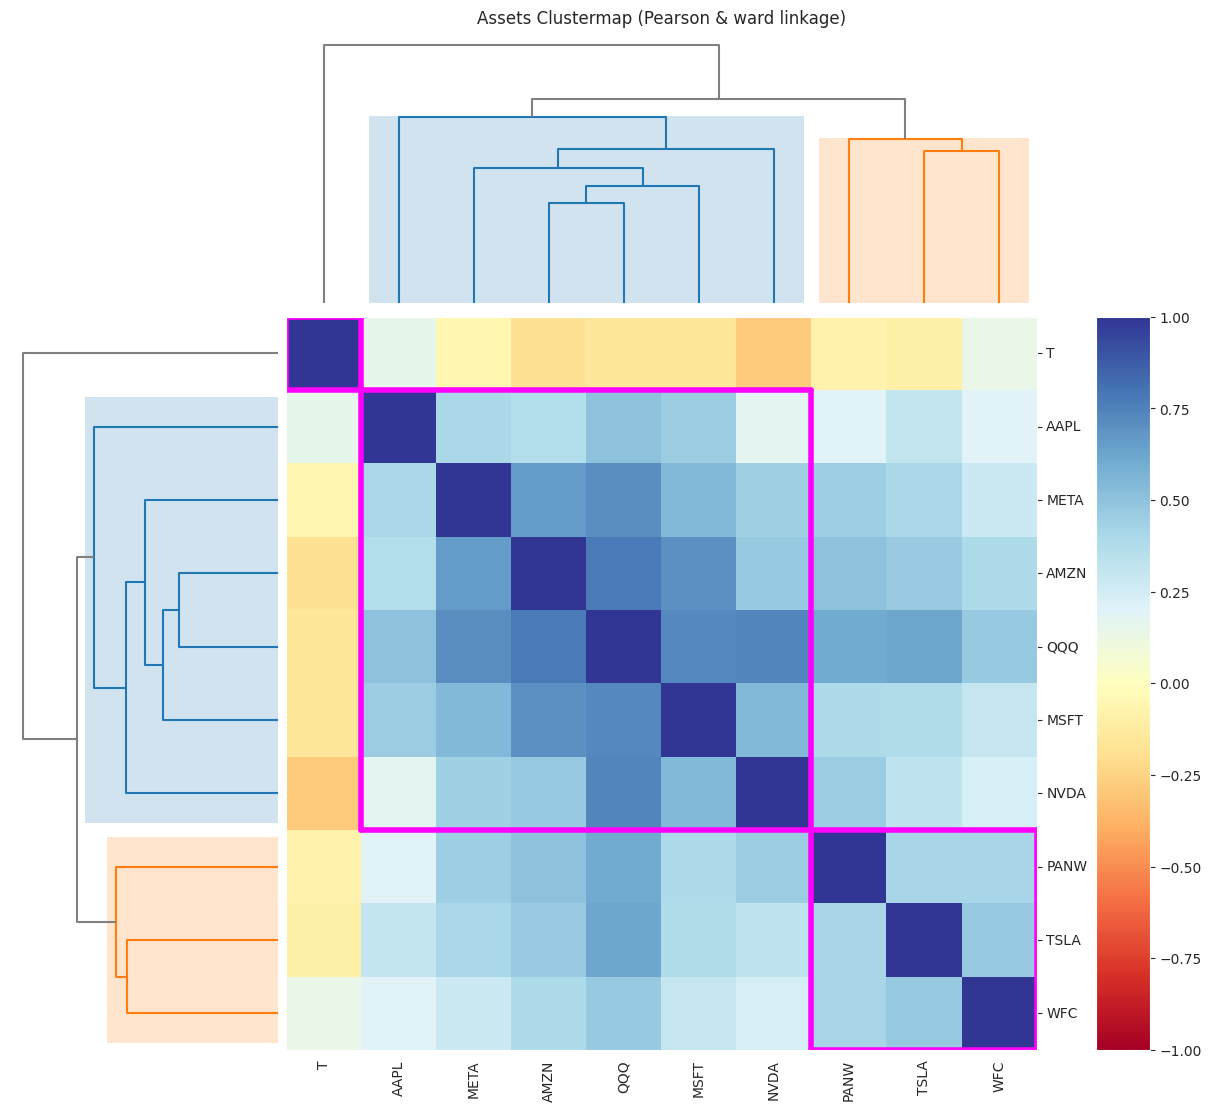

In [13]:
rp.plot_clusters(
    returns=returns,
    codependence='pearson',
    linkage='ward',
    k=None,
    max_k=10,
    leaf_order=True,
    dendrogram=True,
    ax=None
)

The analysis established 3 groups.

## Nested Cluster Optimization
This technique maximizes an objective and incorporates the clustering to reduce the correlation between asset returns

In [14]:
port = rp.HCPortfolio(returns=returns)
w = port.optimization(
    model='NCO',
    codependence='pearson',
    method_cov = 'hist',
    obj = 'Sharpe',
    rm = 'MV',
    rf = 0,
    l=2,
    linkage='ward',
    max_k=10,
)
w

,weights
AAPL,1.744882e-09
AMZN,1.599111e-01
META,1.310709e-10
MSFT,5.645772e-11
NVDA,3.667954e-11
PANW,1.422435e-10
QQQ,1.163282e-10
T,6.552056e-01
TSLA,7.406668e-10
WFC,1.848833e-01


<Axes: title={'center': 'Portfolio Composition'}>

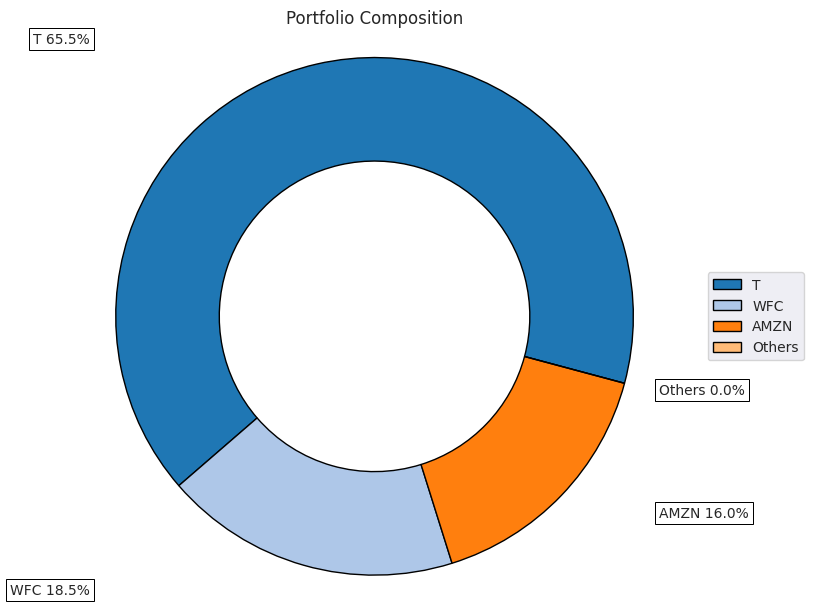

In [16]:
rp.plot_pie(w)

<Axes: >

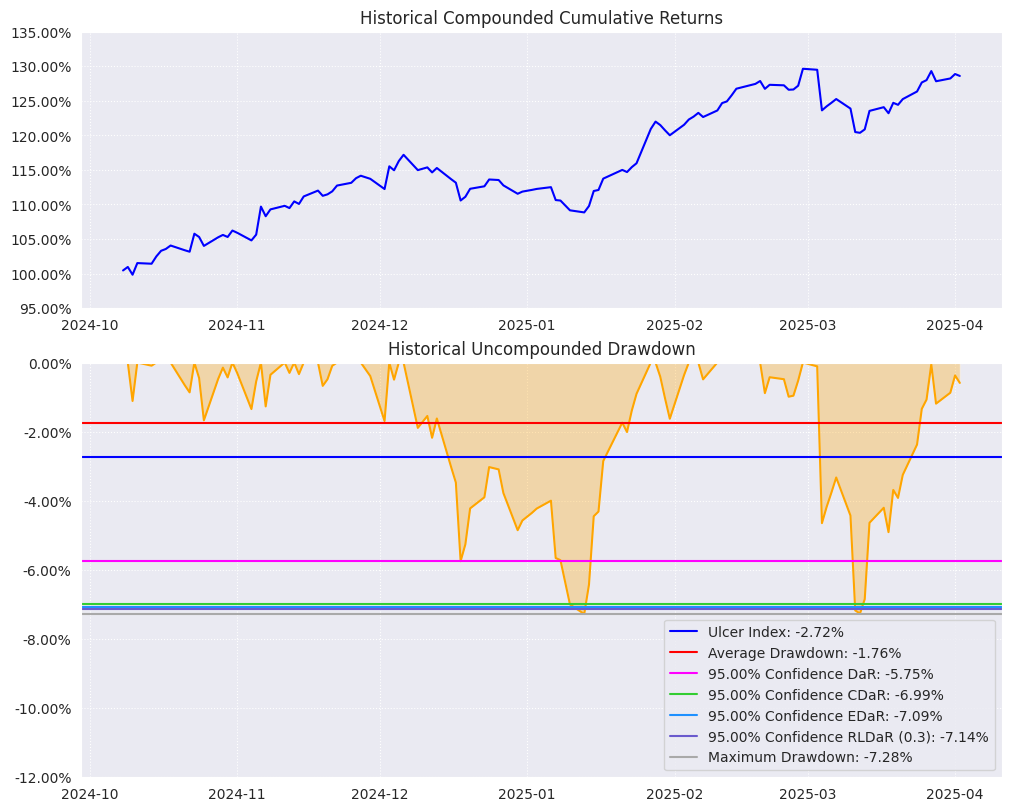

In [17]:
rp.plot_drawdown(returns, w)

In [19]:
portfolio_returns = (returns * w.weights).sum(axis = 1)
portfolio_returns.name = "portfolio_returns"
portfolio_returns

,portfolio_returns
Date,
2024-10-08,0.004558
2024-10-09,0.005017
2024-10-10,-0.011120
2024-10-11,0.016863
2024-10-14,-0.000910
...,...
2025-03-27,0.010221
2025-03-28,-0.011393
2025-03-31,0.003161


In [21]:
!pip install quantstats
import quantstats as qs




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.7 MB/s eta 0:00:00


In [20]:
pf.create_simple_tear_sheet(portfolio_returns, benchmark_rets=returns["QQQ"])

AttributeError: `np.NINF` was removed in the NumPy 2.0 release. Use `-np.inf` instead.

[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-10-08   2024-10-08
End Period                 2025-04-02   2025-04-02
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          -0.93%       28.59%
CAGR﹪                     -1.33%       43.34%

Sharpe                     0.0          3.04
Prob. Sharpe Ratio         50.07%       97.97%
Smart Sharpe               0.0          2.96
Sortino                    0.0          4.83
Smart Sortino              0.0          4.7
Sortino/√2                 0.0          3.42
Smart Sortino/√2           0.0          3.32
Omega                      1.71         1.71

Max Drawdown               -13.19%      -7.15%
Longest DD Days            59           47
Volatility (ann.)          19.98%       17.74%
R^2                        0.05         0.05
Information Ratio          0.14         0.14

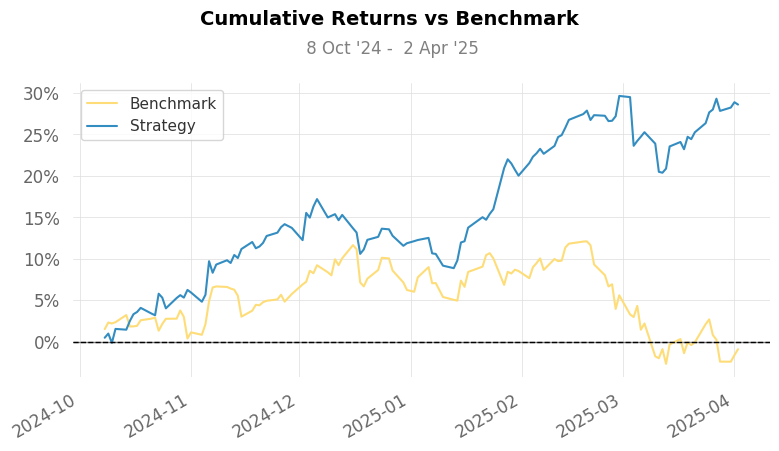

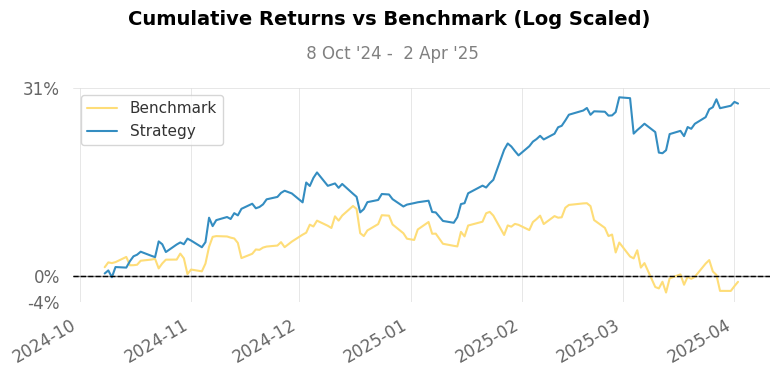

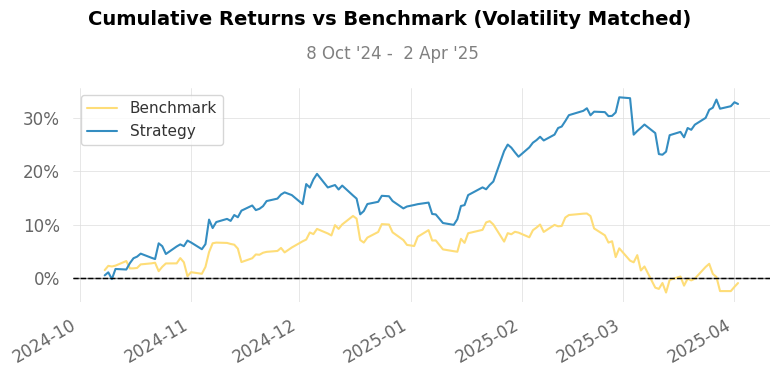

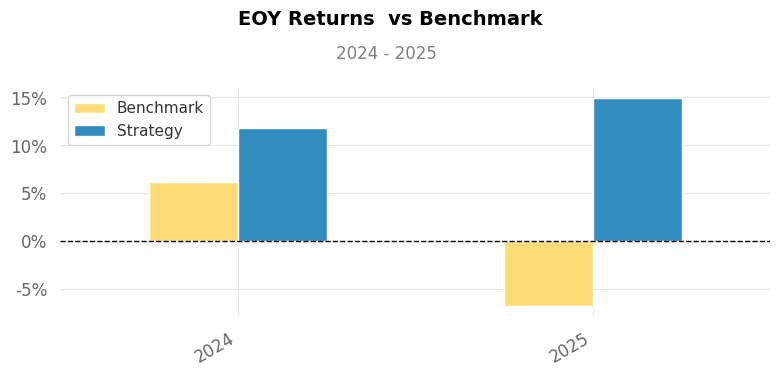

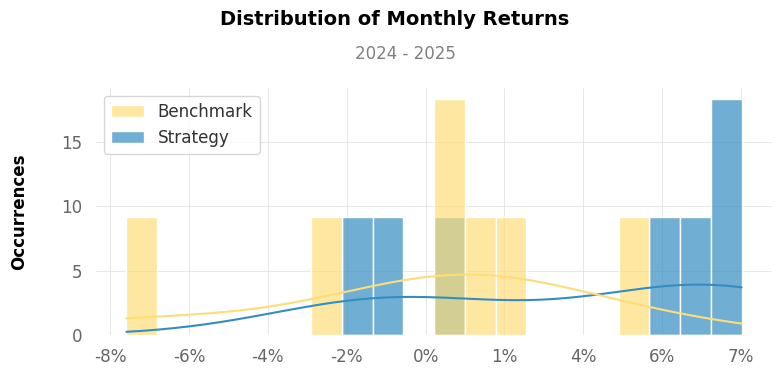

/usr/local/lib/python3.11/dist-packages/quantstats/_plotting/core.py:294: FutureWarning: Passing additional kwargs to DatetimeIndexResampler.sum has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  returns = returns.last() if compound is True else returns.sum(axis=0)


UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [23]:
qs.reports.full(portfolio_returns, benchmark=returns["QQQ"])